# MaSim Country Calibration

This note book is used for running the country calibration processes for eventual use in the experimental simulation process where various response strategies are modeled. This notebook and the accompanying toolkit was developed by [James Brodovsky](https://github.com/jbrodovsky) and Sarit Adhikari as part of the calibration efforts for Burkino Faso and Mozambique in 2025.

## Installation

Installation is in two parts. First, clone this repository to your local machine. Second, install the `masim_analysis` package into a virtual environment, e.g., using `pip` or `uv`.

```bash
pip install -e .
```

If you are using `uv` (and you should!) install via

```bash
uv pip install -e .
```

This will install the package in an editable mode, allowing you to make changes to the code and have them reflected in your local environment. If for some reason you are not seeing the changes reflected, try re-installing the package locally using the above commands again.

Alternatively, and this should be done only if you are developing additional toolbox features, you can run this notebook from the root (top level) directory and direct import calls to the toolbox via 

```python 
from src.masim_analysis import *
```
where `*` is the specific module you are interested in.

## Package and repo structure

Please make note of the following directory structures: `conf` and `data`. These are the primary two directories for experimental country data and configuration files. The `conf` directory contains the configuration (.yml) files for the simulation, while the `data` directory contains the data files used in the simulation (typically raster `.asc` files).

Each of these folders is organized by country. For example, if you are working with Mozambique, which we abrieviate as `moz`, the directory structure would look like this:

```
data/
    moz/
        calibration/
        ...
conf/
    moz/
        calibration/
        ...
```
Additionally the templates folder contains the template files for the configuration files. These are used to generate the .yml files for the simulation. This templating system is gradually being phased out in favor of a more structured approach using Python data classes in the `configure` module. Ultimately, this package communicates with the MaSim simulation through a `.yml` configuration file that can still be created manually if you desire.

## Style guide

This package follows pretty strict styling guidelines for clarity and consistency. The code is formatted and linted using `ruff` and `pyright`. In particular, `pyright` is configured in standard mode, which means that it will check for type errors and other issues in the code. Warnings and errors reported by either of these tools should be addressed before submitting a pull request. In some cases, this may result in somewhat more verbose code, but it is done to ensure that the code is clear and easy to understand. The goal is to make the code as readable and maintainable as possible.

## How to use this notebook

This notebook should be thought of as a structured interactive prompt that guides you through the process of calibrating and validating a country. The code sections are generally organized into sections that can be run independently. The notebook breaks up individual workflows by using markdown headings and note blocks. Due to the some what long-running nature of the tasks that calibration and validation involve, you'll sometimes have to wait and shutdown the kernel the notebook is running on and pick up where you left off another time.

To that end, this notebook is designed to make things organized but also segmented. Keep calibration constants (name, population, etc.) in a block below this and make sure to run that block every time you start the notebook. Module and library imports should be handled in the workflow segment you are currently working on. It is recommend (for speed of execution) to separate out imports from code execution to save time on re-importing.

Workflows are generally separated by a horizontal rule:

--- 

## Calibration efforts

The primary calibration point is to relate the beta parameter (rate of infection/biting) with the actual reported prevelence, given the population size of a given map pixel and treatment access rate. This involves a few steps. As a preliminary step, obtain the relevant raster files that contain population data, district mapping values, treatment access, and prevalence (pfpr2-10, or a similar name) and place it under `data/<country>`. Fictitious calibration data will be stored under `data/<country>/calibration`. Create a new branch in the git repository for the calibration process. This is important to keep track of changes and to avoid conflicts with the main branch. The main branch should be reserved as a branching off point for strategy and treatment analysis or new calibration efforts. The workflow there should be to branch off from the main branch, implement the strategies and treatments, and then merge back in any useful changes. Strategy and treament analysis shouldn't be a main contribution to the main branch. The calibration branch name should be descriptive and include the country name, e.g., `calibration-moz`.

Calibration then occurs in two phases and should be done on a separate git branch. The first phase is generating the simulated data for beta calibration. This creates the fictitious configuration and data files. This concludes with several command and job files to be run on a cluster. At the moment this is configured to work on Temple University's OwlsNest cluster, but the resulting `*_cmds.txt` files simply contain a list of shell commands that execute the simulation and should be generalizable to whatever parallel computing cluster system you are using.

The second phase is started when the batch processing is completed and downloaded locally to the `output/<country>/calibration` directory. These files are then summarized and the prevalence and beta values are fit using a log-sigmoid curve fit when broken down by pixel population and treatment access rate. These fits are then used to generate the beta map for eventual use in the experimental simulation.

---

## Basic parameters

There are a few country specific parameters that we need to develop and organize. These parameters are frequently used and are listed below:

- `name`: The country code name. Usually two or three letters. Examples: `moz` for Mozambique, `bf` for Burkino Faso, `rwa` for Rwanda, `tz` for Tanzania, etc.
- `birth_rate`: The birth rate of the country. This is used to calculate the population growth rate. This is usually a constant value for the country. Data is typically given in births per 1000 people. Normalize that data to a decimal value.
- `target_population`: The population of the country in the calibration target year.
- `initial_age_structure`: The initial age bins of the country. 
- `age_distribution`: The age distribution of the country as percentages corresponding to the age bins.
- `death_rate`: The death rate of the country corresponding to the age bins.
- `access_rates`: the treatment access rates for the country. This is determined by the unique values in the raster file typically called `<name>_treatementseeking.asc`

Some of these are configuration parameters that are fed into the `MaSim` simulation. Others are simply descriptive (e.g. `name`) are are used to organize files. It is useful to have these parameters as variables. Once we have gone through the initial tuning, these parameters are stable and it is useful to simply keep them in a Python source file and import them as neccessary.

## Directory Setup

First: what is the long-form name of the country your are working with?

In [1]:
long_name = "Mozambique"

Second: what is the short-form country code?

In [2]:
name = "moz"

Now we'll do a basic file system configuration for our project.

In [3]:
from masim_analysis import configure

configure.setup_directories(name)

After this initial folder configurat is set up copy the data from the country folder on the drop box into `data/<name>`. This should be a collection of raster (`.asc`) and `.csv` files. At a minimum these should include: 
- `<name>_districts.asc` (mapping of individual raster pixels to larger scale provinces or health districts)
- `<name>_population.asc` (calibration year population)
- `<name>_initialpopulation.asc` (backed out initial population)
- `<name>_pfpr210.asc` (pfpr210 raster)
- `<name>_traveltime.asc` (travel time raster)
- `<name>_treatmentseeking.asc` (treatment seeking raster)

### Raster data exploration

The first calibration step is to read in the relevant rasters to get a sense of some of the big picture data. The rasters are stored in the `data/<country>` directory. This is then used to get some basic statistics to run calibration. Of primary concern is getting the value of the initial population, calibration year population, `

In [4]:
import os
import pandas as pd
from masim_analysis import utils

districts, _ = utils.read_raster(os.path.join("data", name, f"{name}_districts.asc"))
population, _ = utils.read_raster(os.path.join("data", name, f"{name}_initialpopulation.asc"))
prevalence, _ = utils.read_raster(os.path.join("data", name, f"{name}_pfpr210.asc"))
district_names = pd.read_csv(os.path.join("data", name, f"{name}_mapping.csv"), index_col="ID")
names = district_names.to_dict()["DISTRICT"]

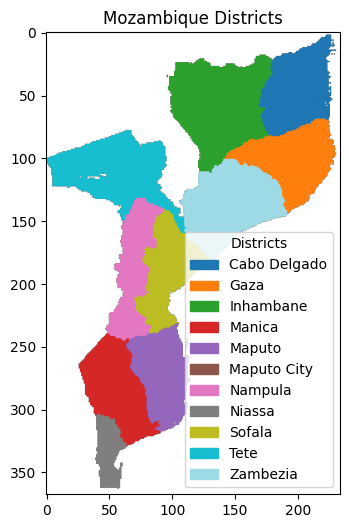

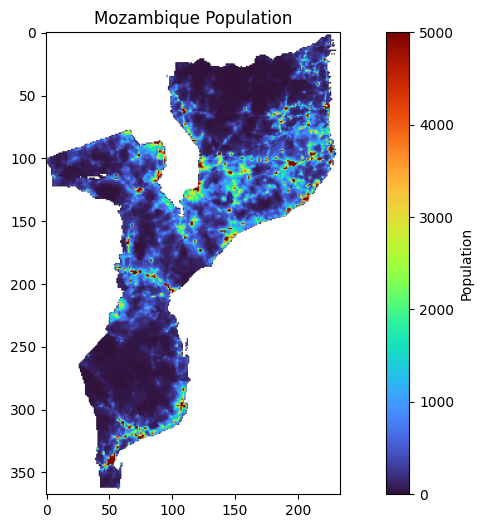

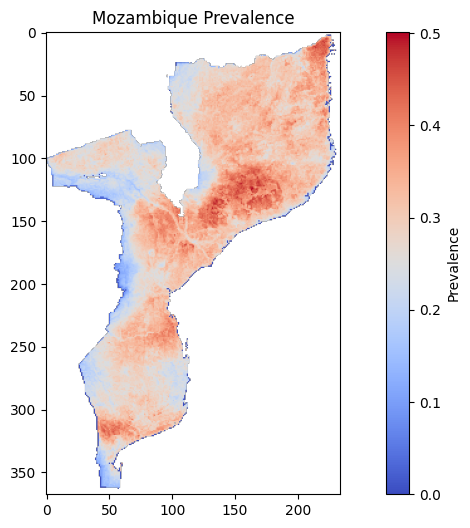

In [5]:
dist_fig = utils.plot_districts(districts, names, "Mozambique", fig_size=(12, 6), loc="lower right")
pop_fig = utils.plot_population(population, "Mozambique", fig_size=(12, 6), population_upper_limit=5000)
pfpr_plot = utils.plot_prevalence(prevalence, "Mozambique", fig_size=(12, 6))

### Drug distribution rates

Each country has a different drug distribution rate. This will factor into the calibration file. Read in the raw file and process it to remove any unnecessary columns or rows.

In [6]:
drug_distribution = pd.read_csv(
    os.path.join("data", name, f"{name}_drugdistribution.csv"), index_col=0, na_values="-99"
)
drug_distribution

,AL,quin,sp,cq,aq,as,other,asaq,aspirin
date,,,,,,,,,
2003,NaN,10.7,10.7,14.9,NaN,14.9,9.8,NaN,7.0
2011,NaN,8.5,23.8,2.8,2.0,NaN,4.6,59.9,NaN
2015,NaN,0.4,7.2,0.3,0.2,NaN,1.5,92.6,NaN
2018,NaN,0.6,0.7,0.3,0.2,0.5,0.2,98.0,NaN
2022,NaN,2.6,2.9,NaN,2.8,6.0,1.4,85.0,NaN
2023,NaN,2.6,2.9,NaN,2.8,6.0,1.4,85.0,NaN


In [7]:
drug_distribution.drop(2003, inplace=True)
drug_distribution.drop(columns=["AL", "aspirin"], inplace=True)
drug_distribution

,quin,sp,cq,aq,as,other,asaq
date,,,,,,,
2011,8.5,23.8,2.8,2.0,NaN,4.6,59.9
2015,0.4,7.2,0.3,0.2,NaN,1.5,92.6
2018,0.6,0.7,0.3,0.2,0.5,0.2,98.0
2022,2.6,2.9,NaN,2.8,6.0,1.4,85.0
2023,2.6,2.9,NaN,2.8,6.0,1.4,85.0


As a sanity check, the sum of the distribution rates should equal 1.0 for each year, but it might not be. The percentages given aren't necessarily exclusive.

In [8]:
drug_distribution["sum"] = drug_distribution.sum(axis=1)
drug_distribution

,quin,sp,cq,aq,as,other,asaq,sum
date,,,,,,,,
2011,8.5,23.8,2.8,2.0,NaN,4.6,59.9,101.6
2015,0.4,7.2,0.3,0.2,NaN,1.5,92.6,102.2
2018,0.6,0.7,0.3,0.2,0.5,0.2,98.0,100.5
2022,2.6,2.9,NaN,2.8,6.0,1.4,85.0,100.7
2023,2.6,2.9,NaN,2.8,6.0,1.4,85.0,100.7


If in the case that the sum of the distribution rates does not equal 1.0, then you will need to normalize the values so that they do for the purposes of the siumulation.

In [9]:
totals = drug_distribution["sum"]
drug_distribution.drop(columns=["sum"], inplace=True)
drug_distribution = drug_distribution.div(totals, axis=0)
drug_distribution

,quin,sp,cq,aq,as,other,asaq
date,,,,,,,
2011,0.083661,0.234252,0.027559,0.019685,NaN,0.045276,0.589567
2015,0.003914,0.070450,0.002935,0.001957,NaN,0.014677,0.906067
2018,0.005970,0.006965,0.002985,0.001990,0.004975,0.001990,0.975124
2022,0.025819,0.028798,NaN,0.027805,0.059583,0.013903,0.844091
2023,0.025819,0.028798,NaN,0.027805,0.059583,0.013903,0.844091


We then relate this to the `DRUG_DB` and `THERAPY_DB` dictionary in `masim_analysis.configure`. Note that the drug distribution may be either a single drug or a combination of drugs. For instance, `al` is a combination of artemether and lumefantrine. This would correspond to a 

In [10]:
from masim_analysis.configure import DRUG_DB, THERAPY_DB

print("Drugs:")
for idx in DRUG_DB.keys():
    print(f"Drug {idx}: {DRUG_DB[idx]['name']}")
print("---")
print("Therapies:")
for idx in THERAPY_DB.keys():
    drug_ids = THERAPY_DB[idx]["drug_id"]
    print(f"Therapy {idx}: {[DRUG_DB[drug_id]['name'] for drug_id in drug_ids]}")

Drugs:
Drug 0: ART
Drug 1: AQ
Drug 2: SP
Drug 3: CQ
Drug 4: LUM
Drug 5: PQ
Drug 6: MF
Drug 7: QUIN
---
Therapies:
Therapy 0: ['ART', 'AQ']
Therapy 1: ['ART', 'LUM']
Therapy 2: ['ART', 'MF']
Therapy 3: ['ART', 'PQ']
Therapy 4: ['AQ']
Therapy 5: ['ART']
Therapy 6: ['CQ']
Therapy 7: ['QUIN']
Therapy 8: ['SP']


Next we need to establish the calibration year, starting date, and ending date of the simulation. The calibration year is the year of the most recent data available, typically 2-3 years old.

In [11]:
calibration_year = 2022

Typical procedure is to back out ten years from the calibration year to establish the starting date for the simulation to permit sufficient "burn in" time and then to run the simulation for an additional year after the calibration year.

In [12]:
from datetime import date

starting_date = date(calibration_year - 11, 1, 1) 
ending_date = date(calibration_year + 1, 12, 31)  
start_of_comparison_period = date(calibration_year, 1, 1)  

From this information we must manually construct the baseline strategy(ies) and event(s) databases. Similar to the drug and therapy "databases" we store the strategies in a dictionary with integer keys. Each key corresponds to a strategy which itself is a dictionary with the following keys:
- `name`: The name of the strategy. This is used to identify the strategy in the simulation.
- `type`: The type of strategy. Leave this as "MFT" until further notice.
- `therapy_ids`: The therapy ids used in the strategy. This is a list of integers corresponding to the therapy ids in the `THERAPY_DB` dictionary.
- `distribution`: The distribution of the strategy. This is a list of floats corresponding to the distribution of the strategy that we derived from the drug distribution rates from DHS data.

In [13]:
from ruamel.yaml import YAML

yaml = YAML()

os.makedirs(os.path.join("conf", name, "test"), exist_ok=True)

strategy_db = {
    0: {
        "name": "2011",
        "type": "MFT",
        "therapy_ids": [7, 8, 6, 4, 5, 1],
        "distribution": [0.083661, 0.234252, 0.027559, 0.019685, 0, 0.589567],
    },
    1: {
        "name": "2015",
        "type": "MFT",
        "therapy_ids": [7, 8, 6, 4, 5, 1],
        "distribution": [0.003914, 0.07045, 0.002935, 0.001957, 0, 0.014677, 0.906067],
    },
    2: {
        "name": "2018",
        "type": "MFT",
        "therapy_ids": [7, 8, 6, 4, 5, 1],
        "distribution": [0.3005970, 0.006965, 0.002985, 0.00199, 0.004975, 0.00199, 0.975124],
    },
    3: {
        "name": "2022",
        "type": "MFT",
        "therapy_ids": [7, 8, 6, 4, 5, 1],
        "distribution": [0.025819, 0.028798, 0, 0.027805, 0.059583, 0.013903, 0.844091],
    },
    4: {
        "name": "2023",
        "type": "MFT",
        "therapy_ids": [7, 8, 6, 4, 5, 1],
        "distribution": [0.025819, 0.028798, 0, 0.027805, 0.059583, 0.013903, 0.844091],
    },
}
yaml.dump(strategy_db, open(os.path.join("conf", name, "test", "strategy_db.yaml"), "w"))

The events database is then similarly constructed from drug distribution table above.

In [14]:
events = [
    {"name": "2011_strategy", "info": [{"day": starting_date, "strategy_id": 0}]},
    {"name": "2015_strategy", "info": [{"day": date(2015, 1, 1).strftime("%Y/%m/%d"), "strategy_id": 1}]},
    {"name": "2018_strategy", "info": [{"day": date(2018, 1, 1).strftime("%Y/%m/%d"), "strategy_id": 2}]},
    {"name": "2022_strategy", "info": [{"day": date(2022, 1, 1).strftime("%Y/%m/%d"), "strategy_id": 3}]},
    {"name": "2023_strategy", "info": [{"day": date(2023, 1, 1).strftime("%Y/%m/%d"), "strategy_id": 4}]},
]
yaml.dump(events, open(os.path.join("conf", name, "test", "events.yaml"), "w"))

## Birth Rate Check

This is all then put together to develop an initial configuration to test these baseline parameters for the growth rate. From the team, data files, and some additional research you need to identify the following parameters:

- `birth_rate`: the country's "crude" birth rate (we will be verifying this number in the step)
- `initial_age_structure`: the distribution of the population across different age groups at the start of the simulation
- `age_distribution`: the corresponding age brackets of the initial age distribution
- `death_rate`: the death rate of the country by age bracket.
- `target_population`: the calibration year's population value of the country

The important calibration point is the final year population. We back out the population data from this using a birth rate. To check that the initialization raster is correct, we need to run an initial simulation run to verify this growth rate considering malaria deaths as well. This is really just a sanity check to make sure the input data is correct.

Run an initial check to make sure the growth rate is working correctly. Given the input file for whatever year, run a single simulation and check that the population for the target year is correct. Make sure to scale the ending population by the simulation scale factor as well.

In [15]:
age_distribution = [ 0.037, 0.132, 0.161, 0.142, 0.090, 0.086, 0.070, 0.052, 0.044, 0.044, 0.031, 0.041, 0.024, 0.017, 0.013, 0.017]
birth_rate = 55.5 / 1000
death_rate = [0.048140, 0.041605, 0.052070, 0.048057, 0.048057, 0.00497, 0.00497, 0.00497, 0.00497, 0.003540, 0.00354, 0.00758, 0.01113, 0.01113, 0.01113]
initial_age_structure = [1, 5, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 100]
target_population = 33_635_160

In [16]:
assert len(age_distribution) == len(initial_age_structure), "Please check to make sure that the values and lengths of age_distribution and initial_age_structure are consistent."

In [17]:
import numpy as np

initial_population = np.nansum(utils.read_raster(os.path.join("data", name, f"{name}_initialpopulation.asc"))[0]) 

Next we'll create a simple simulation run to verify the population growth rate.

In [18]:
from masim_analysis import calibrate, configure

pop = 100_000
params = configure.configure(
    country_code=name,
    birth_rate=birth_rate,
    initial_age_structure=initial_age_structure,
    age_distribution=age_distribution,
    death_rates=death_rate,
    starting_date=starting_date,
    start_of_comparison_period=start_of_comparison_period,
    ending_date=ending_date,
    strategy_db=strategy_db,
    calibration_str=f"growth_validation_{pop}",
    beta_override=0.00,
    population_scalar=1.0,
    calibration=True,
)
params["events"].extend(events)
#params["artificial_rescaling_of_population_size"] = 1.0

yaml.dump(params, open(os.path.join("conf", name, "test", f"{name}_growth_validation_{pop}.yaml"), "w"))

calibrate.write_pixel_data_files(params["raster_db"], pop)

Now we'll run the simulation to verify the population growth rate.

In [19]:
filename = os.path.join("conf", name, "test", f"{name}_growth_validation_{pop}.yaml")
os.makedirs(os.path.join("output", name, "test"), exist_ok=True)
output_file = os.path.join("output", name, "test", f"{name}_growth_validation_{pop}")
os.makedirs(os.path.dirname(output_file), exist_ok=True)

In [ ]:
os.system(f"./bin/MaSim -i ./{filename} -o ./{output_file} -r SQLiteDistrictReporter")

Starting population: 100000
Ending population: 157614
Growth rate: 0.57614
Projected 2022 population: 33460974.629580002
Percent error: -0.5179%


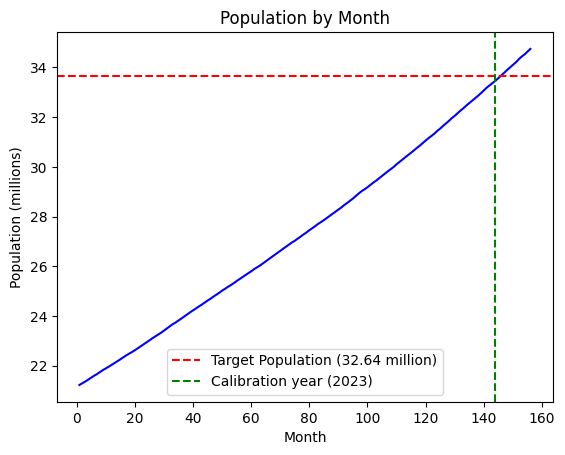

In [20]:
from matplotlib import pyplot as plt
from masim_analysis import analysis

data = analysis.get_table(f"{output_file}monthly_data_0.db", "monthlysitedata")
starting_pop = data[data["monthlydataid"] == 1]["population"].sum()
last_month = data["monthlydataid"].unique()[-13]
population_by_month = [
    data[data["monthlydataid"] == month]["population"].sum() for month in data["monthlydataid"].unique()
]
population_by_month = np.array(population_by_month)
ending_population = population_by_month[-13]
growth_rate = (ending_population - starting_pop) / starting_pop
projected_population = initial_population * (1 + growth_rate)
print(f"Starting population: {starting_pop}")
print(f"Ending population: {ending_population}")
print(f"Growth rate: {growth_rate}")
print(f"Projected {calibration_year} population: {projected_population}")
print(f"Percent error: {100 * (projected_population - target_population) / target_population:.4f}%")

# plots
population_scalar = population_by_month / starting_pop
plt.plot(data["monthlydataid"].unique(), (initial_population * population_scalar) / 1_000_000, linestyle="-", color="b")
plt.axhline(y=target_population / 1_000_000, color="r", linestyle="--", label="Target Population (32.64 million)")
plt.axvline(x=last_month, color="g", linestyle="--", label="Calibration year (2023)")
plt.xlabel("Month")
plt.ylabel("Population (millions)")
plt.title("Population by Month")
plt.legend()
plt.savefig(f"{name}_population_by_month.png")
plt.show()

You should shoot for an absolute error of less than 2%. With that achieved, we can now save off these initial configuration parameters.

In [22]:
import json
from masim_analysis.configure import CountryParams

country = CountryParams(
    name,
    long_name,
    age_distribution,
    birth_rate,
    calibration_year,
    death_rate,
    initial_age_structure,
    target_population,
    starting_date,
    ending_date,
    start_of_comparison_period
)
with open(os.path.join("conf", name, "test", f"{name}_country_params.json"), "w") as f:
    f.write(json.dumps(country.to_dict(), indent=4))

In [25]:
country = CountryParams.load(os.path.join("conf", "moz", "test", f"moz_country_params.json"))

You can now use the data in `country` to access various parameters, namely the country code and long-form name. This is used so that instead of having to run a boilerplate block of code every time you open and run this notebook, you can simply use the single line above.

---

## Seasonality Calibration

Seasonality is a something of a manual process to fit precisely. The goal is to fit a curve that gives a scalar parameter that modifies the incidence rate for each day of the year. This is written to a `.csv` file historically called "adjustment" or "rainfall" and is a simple row-wise list of scalar values that effect the overall incidence or biting rate. This notebook choose to save this output as `seasonality.csv` in the `data/<country>/calibration` directory.

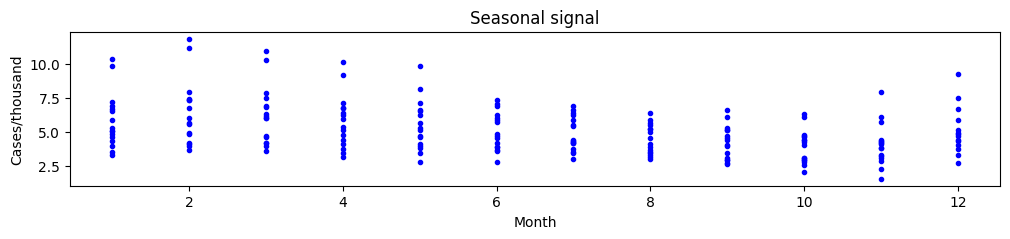

In [26]:
import pandas as pd
from matplotlib import pyplot as plt

country = CountryParams.load(os.path.join("conf", "moz", "test", f"moz_country_params.json"))

cuamba = pd.read_csv(os.path.join("data", country.country_code, "calibration", "incidence cuamba.csv"))
inharrime = pd.read_csv(os.path.join("data", country.country_code, "calibration", "incidence inharrime.csv"))
c = cuamba[["month_num", "cases/thousand"]].copy()
i = inharrime[["month_num", "cases/thousand"]].copy()
s = pd.concat([c, i], axis=0)
s = s.dropna()

x = s["month_num"].to_numpy()
y = s["cases/thousand"].to_numpy()

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y, ".b", label="Data")
ax.set_xlabel("Month")
ax.set_ylabel("Cases/thousand")
ax.set_title("Seasonal signal")
plt.savefig(f"{country.country_code}_seasonal_signal.png")
plt.show()

As we know from previous work, the seasonality of malaria (and most diseases) is roughly sinusoidal. The goal is to fit a sinusoidal curve to the data. With that as well the working assumption of the Boni Lab is to use the positive half of the sine curve. There is not a strong stance on this as seasonal incidence modeling is not a major research concern of the lab. Simply put, taking the positive half of the sine curve is what previous publications from the lab has done and to avoid unneccesary problems in the peer review process, we will continue to do this. This notebook will walk through the process for the full sine curve for completeness' sake.

The fitting is done using the `scipy.optimize.curve_fit` function. The function takes in a model function and the data to fit. The model function is a sinusoidal function with a phase shift, period, amplitude, and offset.

$$
s(x) = A \sin\left(\frac{2 \pi x}{P} + \phi\right) + B
$$

In [27]:
def seasonality(x, amplitude, period, phase, offset):
    """
    Generate a seasonal signal according to a sinusoidal model.
    """
    return amplitude * np.sin((2 * np.pi / period) * (x - phase)) + offset


def seasonality_positive_sine(x, amplitude, period, phase, offset):
    """
    Generate a seasonal signal according to a sinusoidal model.
    """
    s = seasonality(x, amplitude, period, phase, offset)
    s[s <= offset] = offset
    return s

We are looking to fit a scalar multiplier of the base incidence data not a curve over the specific incidence. We can do this by normalizing the incidence data about the median, mean, or mode.

In [ ]:
from scipy.stats import mode as spmode

median = float(np.median(y))
mean = float(np.mean(y))
mode = float(spmode(y).mode)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y, ".b", label="Data")
ax.set_xlabel("Month")
ax.set_ylabel("Cases/thousand")
ax.set_title("Seasonal signal")
ax.axhline(median, color="r", linestyle="--", label="Median")
ax.axhline(mean, color="g", linestyle="--", label="Mean")
ax.axhline(mode, color="y", linestyle="--", label="Mode")
ax.legend(loc="upper right", bbox_to_anchor=(1.12, 1))
plt.savefig(f"{country.country_code}_seasonal_signal.png")
plt.show()

Normailze the data with respect to the mean value.

In [ ]:
y_norm = y / mean

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y_norm, ".b", label="Normalized Data")
ax.set_xlabel("Month")
ax.set_ylabel("Cases / thousand")
ax.set_title("Seasonal signal")
ax.axhline(median / mean, color="r", linestyle="--", label="Normalized Median")
ax.axhline(mean / mean, color="g", linestyle="--", label="Normalized Mean")
ax.axhline(mode / mean, color="y", linestyle="--", label="Normalized Mode")
ax.legend()
plt.savefig(f"{country.country_code}_seasonal_signal_normalized.png")
plt.show()

Run the curve fit function and analyze with resepct to both the full sinusoid and the positive half of the sine curve.

In [ ]:
from scipy.optimize import curve_fit

fit = curve_fit(seasonality, x, y_norm, p0=[1, 365, 0, 1], maxfev=10000)

coefs = fit[0]

t = np.linspace(1, 12, 1000)

full_sine = seasonality(x, *coefs)
r2 = 1 - (np.sum((y_norm - full_sine) ** 2) / np.sum((y_norm - np.mean(y_norm)) ** 2))
std_dev = np.std(y_norm - full_sine)

positive_sine = seasonality_positive_sine(x, *coefs)
r2_positive = 1 - (np.sum((y_norm - positive_sine) ** 2) / np.sum((y_norm - np.mean(y_norm)) ** 2))
std_dev_positive = np.std(y_norm - positive_sine)

fig, ax = plt.subplots(figsize=(12, 2))
ax.plot(x, y_norm, ".b", label="Data (scaled)")
ax.plot(t, seasonality(t, *coefs), "r-", label=f"Fitted curve\n$r^2$ = {r2:0.2f}\n$\sigma$: {std_dev:0.2f}")
ax.plot(
    t,
    seasonality_positive_sine(t, *coefs),
    "g--",
    label=f"Fitted curve (positive sine)\n$r^2$ = {r2_positive:0.2f}\n$\sigma$: {std_dev_positive:0.2f}",
)
ax.set_xlabel("Month")
ax.set_ylabel("Incidence Scalar")
ax.legend(loc="upper right", bbox_to_anchor=(0.65, -0.35))
plt.title("Seasonal signal with fitted curves")
plt.savefig(f"{country.country_code}_seasonal_signal_fitted.png", bbox_inches="tight")
plt.show()

The fit is not great, but this is a relatively minor aspect of the simulation. The point is to introduce some degree of seasonal variation that is reasonable. Now let's transform the fit back to the incidence rate.

In [ ]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(x, y, ".b", label="Data (scaled)")
ax.plot(t, seasonality_positive_sine(t, *coefs) * mean, "g--", label="Fitted curve; $r^2$ = %.2f" % r2)
ax.legend()
ax.set_xlabel("Month")
ax.set_ylabel("Cases/thousand")
ax.set_title("Seasonal signal with fitted positive sine curve")
fig.savefig(f"{country.country_code}_seasonal_signal_fitted_positive.png")
plt.show()

In [ ]:
# Write the fit to a file for 365 days
fit_x = np.arange(1, 366)
fit_y = seasonality_positive_sine(fit_x, *fit[0])
data = pd.DataFrame({"day": fit_x, "cases/thousand": fit_y})
data = data.set_index("day")
data.to_csv(os.path.join("data", country.country_code, f"{country.country_code}_seasonality.csv"), index=False, header=False)

===========================

Begin push-button automatic country model generation

## Run calibration data generation

The unknown that we are trying to solve for is the beta value(s). We have _real_ pixel-wise _prevalence_ (pfpr2-10) data that arrises from a given beta. The goal is to generate data that matches closely the real prevalence data by varying the beta value, population size, and access rate for a simulated single pixel. We will first generate the configuration files for the calibration runs here. 

In [ ]:
# Country calibration script
import os
from datetime import date
from ruamel.yaml import YAML

from masim_analysis import calibrate
from masim_analysis.configure import CountryParams

yaml = YAML()

country = CountryParams.load(os.path.join("conf", "moz", "test", f"moz_country_params.json"))

In [ ]:
# Get the unique treatment access rates
treatment, _ = utils.read_raster(os.path.join("data", country.country_code, f"{country.country_code}_treatmentseeking.asc"))
treatment = np.unique(treatment)
treatment = treatment[~np.isnan(treatment)]
treatment = np.sort(treatment)
access_rates = [float(t) for t in treatment]  # Convert to float for consistency and to make pyright happy

events = yaml.load(open(os.path.join("conf", country.country_code, "test", "events.yaml"), "r"))
strategy_db = yaml.load(open(os.path.join("conf", country.country_code, "test", "strategy_db.yaml"), "r"))

calibrate.generate_configuration_files(
    country.country_code,
    calibration_year,
    [],
    access_rates,
    [],
    birth_rate,
    death_rate,
    initial_age_structure,
    age_distribution,
    strategy_db=strategy_db,
    events=events,
)

Create the command and job files

In [ ]:
calibrate.generate_command_and_job_files(
    name,
    [],
    access_rates,
    [],
    cores=28,
    nodes=8,
)

At this point you should have all the data and configuration files you need in order to run the calibration. The next step is to commit the changes (added files) to the local branch and push to the remote branch. Log into the cluster and switch to the branch you just created:

```bash
git checkout <branch_name>
git pull
```
Create the required output directories on the cluster: 

```bash
mkdir -p output/<country>/calibration
```

Ensure that the jobs files (typically `.sh`) are only the specific jobs that you want to run. Delete any other job or `.sh` files. Keep in mind that any given user may only have at most 50 jobs queued on Owl's Nest at a time. Queue up the calibration jobs using the following command:

```bash
for i in $(ls *.sh); do
    echo "Submitting job $i"
    qsub $i
done
```

This will submit all the jobs in the current directory. Give it a few minutes to queue up and then log into your cluster account and check the status of the jobs. At steady state, each job should be running approximately 28 processess simultaneously. The lower population size pixels do not take very long to run when spread out over several nodes (4-8, approximately 5-10 minutes). The larger population sizes (10k-20k) take much longer (about an hour).




---

## Check for missing data

Once the jobs are completed, you will need to download the output files from the cluster. This can be done using `scp` or `rsync`. For example, to download the output files from Owl's Nest to your local machine, you can use the following command:

```bash
scp -r <username>@<cluster_address>:Temple-Malaria-Simulation-Analysis/output <local_path>
```
This will download the output files to the specified local path. I recommend simply copying them to your desktop. Once you have downloaded the output files, copy them to this repo (or download directly) and place them in the `output/<country>/calibration` directory. This will allow you to run the analysis on the simulated data locally.

Assuming that all or most of the calibration simulation executed successfull, delete all job and commands files in the local repository. Do not delete the files on the cluster! This will cause a git tracking issue as the repository branches will be out of sync.

Prior to running the full calibration analysis, check for any missing data files. Sometimes Owl's Nest gets hung, the database file didn't write correctly, the job times out, or some other bug happened. First, a sanity check. We should have the following number of output calibration files.

In [ ]:
import os

needed_files = len(population_bins) * len(access_rates) * len(betas) * reps
output_dir = os.path.join("output", name, "calibration")
output_files = os.listdir(output_dir)
completed_files = len(output_files)

print(f"Total calibration files: {needed_files}")
print(f"Completed calibration files: {completed_files}")
print(f"Missing calibration files: {needed_files - completed_files}")

If there are missing files use the below block to check for the missing output and create the appropriate job and commands files. You should also double check that each permutation is completed using `process_missing_jobs` prior to moving onto the calibration curve fitting. If there are no missing files proceed to the next section.

In [ ]:
import os
from datetime import date

import pandas as pd

from masim_analysis import calibrate

base_file_path = os.path.join("output", name, "calibration")
summary = pd.DataFrame(columns=["population", "access_rate", "beta", "iteration", "pfprunder5", "pfpr2to10", "pfprall"])

comparison = date(calibration_year, 1, 1)
year_start = comparison.strftime("%Y-%m-%d")
year_end = (comparison + pd.DateOffset(years=1)).strftime("%Y-%m-%d")

In [ ]:
calibrate.process_missing_jobs(
    name,
    population_bins,
    access_rates,
    betas,
    os.path.join("output"),
    reps,
)

If there are any missing data files run them on the cluster. This can be done by running the following command:

```bash
qsub missing_calibration_runs_<pop>_job.sh
```

As an alternative, if there aren't too many missing files you can run them in parallel locally. I like to use [NuShell](https://www.nushell.sh/) to do this because it makes tasks like this much easier to execute. Plus it's fast and written in Rust. Keep in mind that NuShell cannot directly execute strings in scripts like `sh`, `bash`, `zsh`, or normal interaction with `nushell` on the terminal. When `nushell` reads in a text file it assumes the file contains valid `nu` commands. 

Using `nushell` this task can be accomplished by running the following command:

```nushell
let max_parallel = (sys cpu | length) # - 1; # If you wish to leave a few cores free for other tasks
open missing_calibration_runs_<pop>.txt | lines | par-each --threads $max_parallel { |cmd| ^sh -c $cmd }
```

or, alternatively, if you are using `bash` or `zsh` you can run the following command:

```bash
while IFS= read -r line || [[ -n "$line" ]]; do
    if [[ -n "$line" ]]; then
        eval "$line" &
    fi
done < ./missing_calibration_runs_<pop>.txt
```
---

### Summarize data

Once all the appropriate calibration data has been collected we need to summarize across all the individual data files. This will write the summarized results to `calibration_summary.csv` file in the `output/<country>/calibration` directory. The summary file will contain the following columns:
- `beta`: the beta value used in the simulation
- `population`: the population size of the pixel
- `access_rate`: the treatment access rate of the pixel
- `pfpr2_10`: the pfpr2-10 value of the pixel
- `pfprunder5`: the mean pfpr under 5 value of the pixel
- `pfprall`: the mean pfpr value of the pixel
- `iteration` : the iteration number of the simulation


In [ ]:
from masim_analysis import analysis, calibrate

data = analysis.get_table("output/moz/calibration/cal_10000_0.451_0.0125_monthly_data_1.db", "monthlysitedata")
end_month = data["monthlydataid"].unique()[-13]
year = data.loc[data["monthlydataid"].between(end_month-12, end_month, inclusive="left")]
base_file_path = os.path.join("output", name, "calibration")

summary = calibrate.summarize_calibration_results(
    name,
    population_bins,
    access_rates,
    betas,
    end_month-12,
    end_month,
    os.path.join("output"),
    reps,
)
summary["pfprunder5"] = summary["pfprunder5"].div(100)
summary["pfpr2to10"] = summary["pfpr2to10"].div(100)
summary["pfprall"] = summary["pfprall"].div(100)
summary = summary.drop(columns=["iteration"])
summary = summary.groupby(["population", "access_rate", "beta"]).mean().reset_index()
summary.to_csv(f"{base_file_path}/calibration_means.csv", index=False)
summary.head(25)

---

## Curve fitting

Now that we have summarized data that connects population size, treatment access, transmission rate, and prevelence, we can fit the data to a linear and log-sigmoid curve. Generally, the log-sigmoid appears to model the relationship better, but both methods are here for reference. This will allow us to generate a beta map for the experimental simulation. The beta map is generated by taking the beta value that corresponds to the population size and treatment access rate of each pixel. This is done using the `generate_beta_map` function, which takes the summarized data and generates a beta map for the experimental simulation.

Again, the point of this fit is to relate the measured prevalence to the beta value by way of population size and treatment access rate.

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit

from masim_analysis import calibrate

base_file_path = os.path.join("output", name, "calibration")
means = pd.read_csv(f"{base_file_path}/calibration_means.csv")

### Linear fit

We're looking to fit the pfpr to beta relationship so that we can then use the real pfpr value from the raster data to determine the beta value. So, given a specific pixel's population, pfpr, and access rate (treatmentseeking?) calculate the beta value from this fitting method. We also don't have a decent way to serialize the linear models returned from sklearn, so at the moment this is just here for demonstration purposes.

Start using linear regression.

In [ ]:
# Determine grid size
num_rows = len(population_bins)
num_cols = len(access_rates)

# Create subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Ensure axes is always a 2D list for consistency
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array
if num_cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array

poly_fit = {
    access_rate: {population: None for population in population_bins} for access_rate in access_rates
}
# Perform regression for each (Population, TreatmentAccess) group
for i, population in enumerate(population_bins):
    for j, treatment_access in enumerate(access_rates):
        ax = axes[i, j]  # Select subplot location

        # Filter the data for the current Population and TreatmentAccess
        group = means[(means["population"] == population) & (means["access_rate"] == treatment_access)]

        if group.empty:
            ax.set_visible(False)  # Hide empty plots
            continue

        group = group.dropna(axis=0)  # drop any row in a nan column

        X = group[["beta"]].values
        y = group["pfpr2to10"].values

        # 1. Linear Regression
        model = LinearRegression()
        model.fit(X, y)  # type: ignore

        # 2. Polynomial Regression (degree 3)
        poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
        poly_model3.fit(X, y)

        # 3. Polynomial Regression (degree 5)
        poly_model5 = make_pipeline(PolynomialFeatures(5), LinearRegression())
        poly_model5.fit(X, y)

        # 4. Spline Regression
        # spline_model = UnivariateSpline(group['beta'], group['pfpr2to10'], s=50)

        # Plot regression
        sns.scatterplot(x=group["beta"], y=group["pfpr2to10"], ax=ax, label="Data", color="black")
        ax.plot(group["beta"], model.predict(X), color="red", linestyle="dashed", label="Linear")
        ax.plot(group["beta"], poly_model3.predict(X), color="blue", linestyle="dashed", label="Poly (3)")
        ax.plot(group["beta"], poly_model5.predict(X), color="green", linestyle="dashed", label="Poly (5)")
        # ax.plot(group['Beta'], spline_model(X), color='purple', linestyle="dashed", label="Spline")
        poly_fit[treatment_access][population] = {
            "linear": model,
            "poly3": poly_model3,
            "poly5": poly_model5,
            # "spline": spline_model
        }
        # Setting titles & labels
        ax.set_title(f"Population : {population}, Access : {treatment_access}")
        if j == 0:
            ax.set_ylabel("pfpr2to10")
        if i == num_rows - 1:
            ax.set_xlabel("Beta")
        ax.legend(fontsize=7)

# Adjust layout
plt.suptitle("Curve Fitting by Population & Treatment Access", fontsize=16)
plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.96))
plt.savefig(f"{name}_linear_calibration_curve_fitting.png")
plt.show()

Now we'll do a logarithemic fit for the beta value and attempt to fit a sigmoid curve. Again this is the model that typically works best for the data. The fit returned is a list of the parameters for the sigmoid function which can be easily serialized and saved to a file. The sigmoid function is defined as:

$$s = \frac{a}{1 + e^{-b(x - c)}}$$

which in code is:

```python
def sigmoid(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))
```
where `a`, `b`, and `c` are the parameters of the sigmoid function. The `x` value is the beta value. The `a` parameter is the maximum value of the sigmoid function, the `b` parameter is the steepness of the curve, and the `c` parameter is the x-value of the sigmoid's midpoint.

In [ ]:
models_map = calibrate.get_beta_models(
    populations=population_bins,
    access_rates=access_rates,
    means=means,
    pfpr_cutoff=0.0,
)
models_map_filename = "models_map.json"
with open(os.path.join("data", name, "calibration", models_map_filename), "w") as f:  # noqa: F811, ruff disabled
    json.dump(models_map, f, indent=4)

In [ ]:
# Plot all the model data, fits, and inverse fits on the same figure
num_rows = len(population_bins)
num_cols = len(access_rates)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)
for i, population in enumerate(population_bins):
    for j, treatment_access in enumerate(access_rates):
        ax = axes[i, j]  # Select subplot location
        coefs = models_map[treatment_access][population]
        group = means[(means["population"] == population) & (means["access_rate"] == treatment_access)]
        betas = group["beta"].to_numpy()
        pfpr = group["pfpr2to10"].to_numpy()
        
        ax.plot(betas, pfpr, ".", label="Data", color="black")
        X = np.linspace(1e-4, 10, 10000)
        try:
            Y = calibrate.sigmoid(np.log10(X), *coefs)
            ax.plot(X, Y, color="red", label="Fitted Curve")
        except Exception as e:
            print(f"Error fitting sigmoid for Population: {population}, Access: {treatment_access} - {e}")
        
        ax.set_xscale("log")
        ax.set_xlabel("Beta")
        ax.set_ylabel("pfpr2to10")
        ax.set_title(f"Population : {population}, Access : {treatment_access}")
        ax.legend(fontsize=7)
        ax.set_xlim(1e-3, 10)
        ax.set_ylim(0, 1)
        
# Adjust layout
plt.suptitle("pfPr vs. Beta Data and Curve Fits by Population & Treatment Access", fontsize=24)
plt.tight_layout(rect=(0.0, 0.0, 1.0, 0.96))
plt.savefig(f"{name}_log_sigmoid_fit_2.png")
plt.show()

---

Keep in mind that the built in JSON serialization and deserialization reads in all the values as strings. To get around this use `load_beta_model` from the `calibrate` module instead of the native `json.load()` function. This will convert the values back to numeric values and lists where appropriate.

In [62]:
import os

from matplotlib import pyplot as plt

from masim_analysis import calibrate, utils
from masim_analysis.configure import CountryParams

country = CountryParams.load(os.path.join("conf", "moz", "test", f"moz_country_params.json"))

models_map_filename = "models_map.json"

In [63]:
models_map = calibrate.load_beta_model(os.path.join("data", country.country_code, "calibration", models_map_filename))

We can then use this model to generate the beta map for the experimental simulation. The beta map is generated by taking the beta value that corresponds to the population size and treatment access rate of each pixel. This is done using the `create_beta_map` function, which takes the summarized data and generates a beta map for the experimental simulation.

In [64]:
population, raster_params = utils.read_raster(f"data/{country.country_code}/{country.country_code}_population.asc")
prevalence, _ = utils.read_raster(f"data/{country.country_code}/{country.country_code}_pfpr210.asc")
treatment, _ = utils.read_raster(f"data/{country.country_code}/{country.country_code}_treatmentseeking.asc")
districts, _ = utils.read_raster(f"data/{country.country_code}/{country.country_code}_districts.asc")

beta_map = calibrate.create_beta_map(models_map, population, treatment, prevalence)
beta_map *= 1.0
pfpr_predicted = calibrate.predicted_prevalence(models_map, population, treatment, beta_map)

/home/james/Code/Temple-Malaria-Simulation-Analysis/src/masim_analysis/calibrate.py:617: RuntimeWarning: divide by zero encountered in scalar divide
  beta_log = c - (1 / b) * np.log(a / pfpr - 1)
/home/james/Code/Temple-Malaria-Simulation-Analysis/src/masim_analysis/calibrate.py:651: RuntimeWarning: divide by zero encountered in log
  pfpr_map[r, c] = sigmoid(np.log(beta_map[r, c]), *coefs)


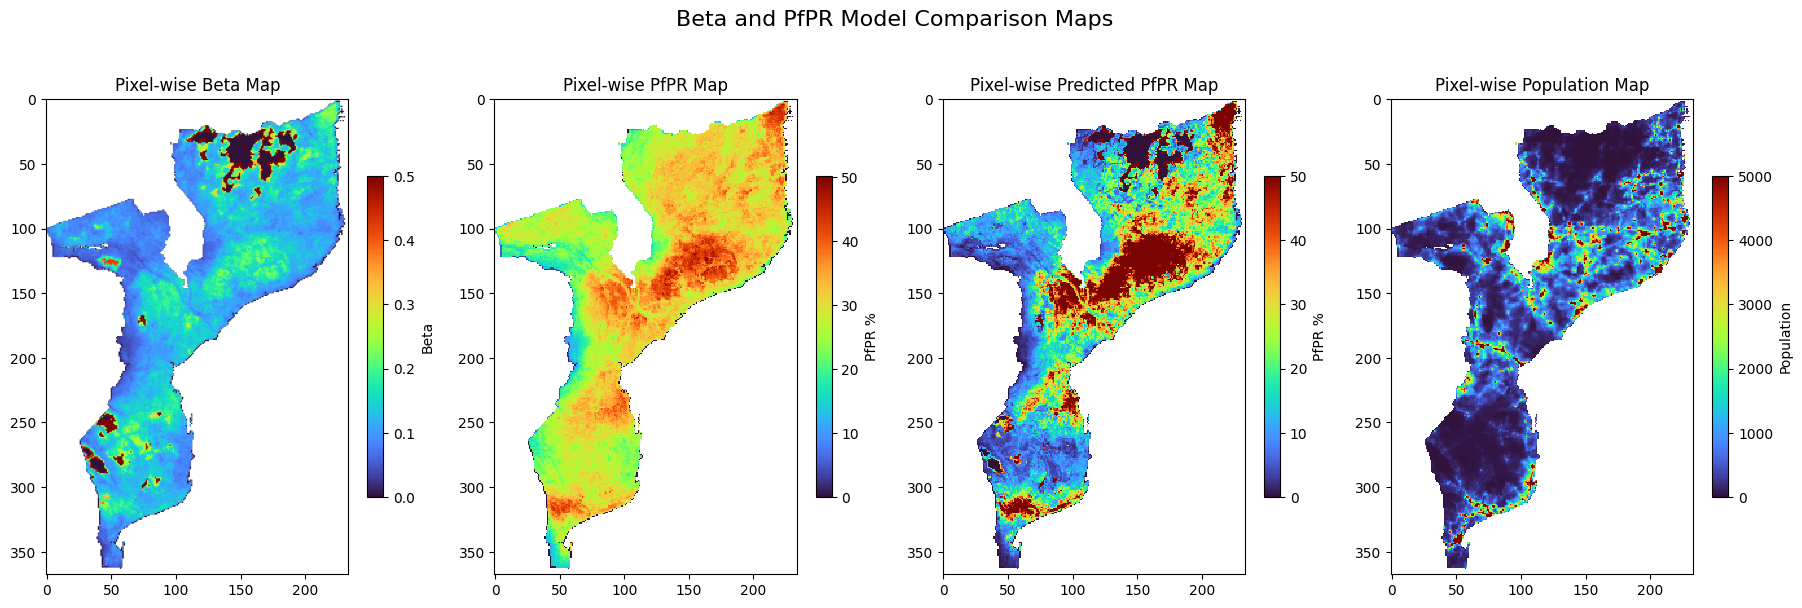

In [65]:
fig, ax = plt.subplots(1, 4, figsize=(18, 7))
im0 = ax[0].imshow(beta_map, cmap="turbo")
fig.colorbar(im0, ax=ax[0], shrink=0.5, label="Beta")
ax[0].set_title("Pixel-wise Beta Map")
im0.set_clim(0, 0.5)  # Set color limits for better visualization

im1 = ax[1].imshow(prevalence * 100, cmap="turbo", interpolation="nearest")
fig.colorbar(im1, ax=ax[1], shrink=0.5, label="PfPR %")
ax[1].set_title("Pixel-wise PfPR Map")
im1.set_clim(0, np.nanmax(prevalence)*100)  # Set color limits for better visualization
#plt.savefig(f"{name}_beta_map_3.png", dpi=600, bbox_inches="tight")

im2 = ax[2].imshow(pfpr_predicted * 100 * 12, cmap="turbo", interpolation="nearest")
fig.colorbar(im2, ax=ax[2], shrink=0.5, label="PfPR %")
ax[2].set_title("Pixel-wise Predicted PfPR Map")
im2.set_clim(0, 50)  # Set color limits
plt.tight_layout()

im3 = ax[3].imshow(population, cmap="turbo", interpolation="nearest")
fig.colorbar(im3, ax=ax[3], shrink=0.5, label="Population")
ax[3].set_title("Pixel-wise Population Map")
im3.set_clim(0, 5000)  # Set color limits for better visualization
fig.suptitle("Beta and PfPR Model Comparison Maps", fontsize=16)

plt.savefig(f"{country.country_code}_comparison_maps.png", dpi=600, bbox_inches="tight")
plt.show()

### Subsectioning

This was done as a sanity check. Can probably be excluded in the full pipeline.

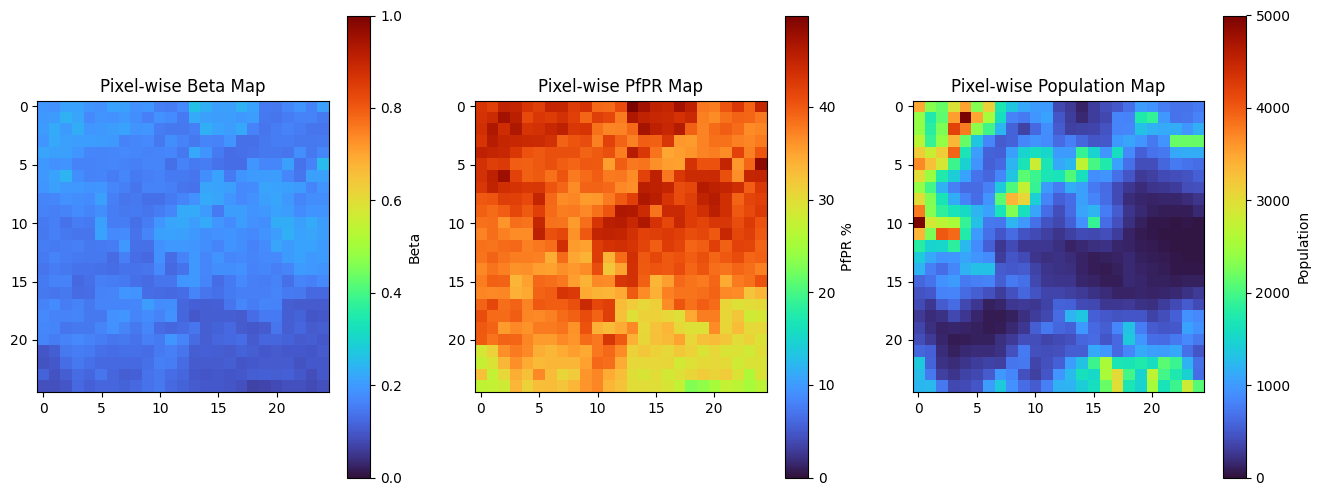

In [66]:
beta_sub = beta_map[125:150, 150:175]
prevalence_sub = prevalence[125:150, 150:175]
population_sub = population[125:150, 150:175]
treatment_sub = treatment[125:150, 150:175]
district_sub = np.zeros_like(districts[125:150, 150:175])

utils.write_raster(beta_sub, "moz_beta_sub.asc", 0, 0)
utils.write_raster(prevalence_sub, "moz_pfpr_sub.asc", 0, 0)
utils.write_raster(treatment_sub, "moz_treatment_sub.asc", 0, 0)
utils.write_raster(population_sub, "moz_population_sub.asc", 0, 0)
utils.write_raster(district_sub, "moz_districts_sub.asc", 0, 0)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
im0 = ax[0].imshow(beta_sub, cmap="turbo", interpolation="nearest")
plt.colorbar(im0, ax=ax[0], label="Beta")
ax[0].set_title("Pixel-wise Beta Map")
#im0.set_clim(0, np.nanmax(beta_map))  # Set color limits for better visualization
im0.set_clim(0, 1)  # Set color limits for better visualization

im1 = ax[1].imshow(prevalence_sub * 100, cmap="turbo", interpolation="nearest")
plt.colorbar(im1, ax=ax[1], label="PfPR %")
ax[1].set_title("Pixel-wise PfPR Map")
im1.set_clim(0, np.nanmax(prevalence_sub)*100)  # Set color limits for better visualization
#plt.savefig(f"{name}_beta_map_3.png", dpi=600, bbox_inches="tight")

im2 = ax[2].imshow(population_sub, cmap="turbo", interpolation="nearest")
plt.colorbar(im2, ax=ax[2], label="Population")
ax[2].set_title("Pixel-wise Population Map")
#im2.set_clim(0, np.nanmax(population))  # Set color limits
im2.set_clim(0, 5000)  # Set color limits for better visualization
plt.savefig(f"{name}_subsection.png", dpi=600, bbox_inches="tight")
plt.show()

---

## Validation

The validation process is similar to the calibration process except that we now use the fitted modelled beta map to attempt to recreate the prevelance map.

In [67]:
import os
from datetime import date

from masim_analysis import configure
from masim_analysis.configure import CountryParams

country = CountryParams.load("conf/moz/test/moz_country_params.json")

In [58]:
strategy_db = yaml.load(open(os.path.join("conf", country.country_code, "test", "strategy_db.yaml"), "r"))
events = yaml.load(open(os.path.join("conf", country.country_code, "test", "events.yaml"), "r"))
params = configure.configure(
    country_code=country.country_code,
    birth_rate=country.birth_rate,
    initial_age_structure=country.initial_age_structure,
    age_distribution=country.age_distribution,
    death_rates=country.death_rate,
    starting_date=country.starting_date,
    start_of_comparison_period=country.start_of_comparison_period,
    ending_date=country.ending_date,
    strategy_db=strategy_db,
    calibration_str="",
    calibration=False,
)
params["events"].extend(events)

params['raster_db']['population_raster'] = "moz_population_sub.asc"
params['raster_db']['pf_treatment_under5'] = "moz_treatment_sub.asc"
params['raster_db']['pf_treatment_over5'] = "moz_treatment_sub.asc"
params['raster_db']['prevalence_raster'] = "moz_pfpr_sub.asc"
params['raster_db']['district_raster'] = "moz_districts_sub.asc"
params['raster_db']['beta_raster'] = "moz_beta_sub.asc"
yaml.dump(params, open("moz_subsection.yml", "w"))

itr = '4e'

In [ ]:
os.system(f"./bin/MaSim -i ./moz_subsection.yml -o ./output/moz_subsection_{itr}_ -r SQLitePixelReporter")

In [68]:
from masim_analysis import analysis

data = analysis.get_table(f"./output/moz_subsection_{itr}_monthly_data_0.db", "monthlysitedata")
months = data["monthlydataid"].unique()
ending_month = months[-13]
starting_month = ending_month - 12
year = data.loc[data["monthlydataid"].between(starting_month, ending_month, inclusive='left')]

prev = year[['locationid', 'pfprunder5', 'pfpr2to10', 'pfprall']].groupby('locationid').mean()
population = year[['locationid', 'population']].groupby('locationid').mean()

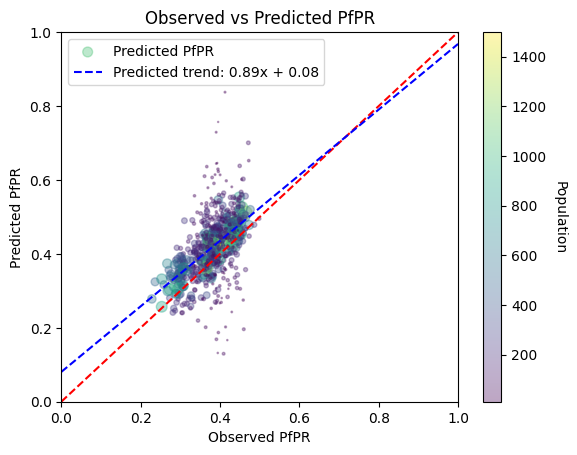

In [69]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    """
    Linear function for curve fitting.
    """
    return a * x + b

X = prevalence_sub.reshape(-1)
Y = prev['pfpr2to10'].to_numpy() / 100

linear_trend, _ = curve_fit(linear, X, Y, p0=[1, 0], maxfev=10000)

plt.scatter(X, Y, s=population['population'] / population['population'].max() * 100, marker="o", alpha=0.35, cmap="viridis", c=population['population'], label="Predicted PfPR")
cbar = plt.colorbar()
cbar.set_label("Population", rotation=270, labelpad=15)
x = np.linspace(0, 1, 1000)
plt.plot(x, x, color="red", linestyle="--")
plt.plot(x, linear_trend[0] * x + linear_trend[1], color="blue", linestyle="--", label=f"Predicted trend: {linear_trend[0]:.2f}x + {linear_trend[1]:.2f}")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Observed PfPR")
plt.ylabel("Predicted PfPR")
plt.title("Observed vs Predicted PfPR")
plt.legend()
plt.savefig(f"{name}_observed_vs_predicted_pfpr_{itr}.png", dpi=600, bbox_inches="tight")
plt.show()

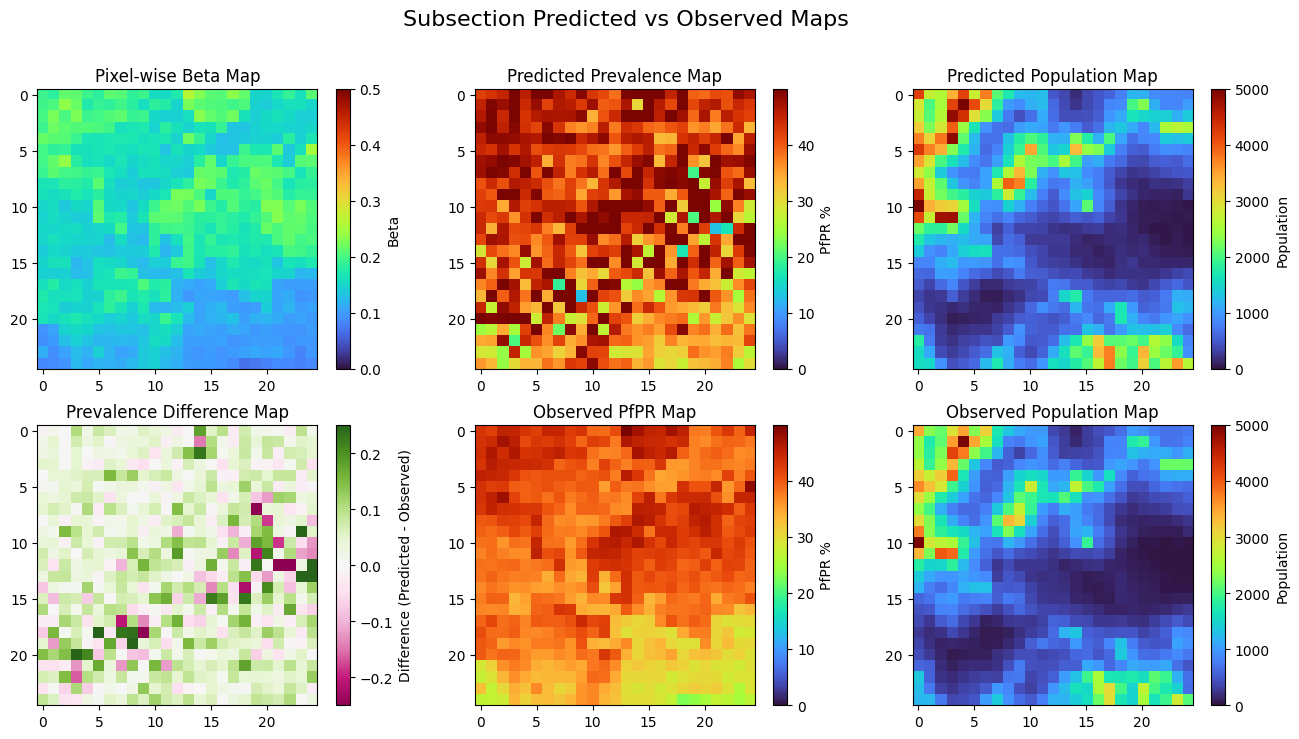

In [70]:
diff = prev['pfpr2to10'].to_numpy().reshape(25, 25) / 100 - prevalence_sub

fig, ax = plt.subplots(2, 3, figsize=(16, 8))

im0 = ax[0, 0].imshow(beta_sub, cmap="turbo")
fig.colorbar(im0, ax=ax[0, 0], label="Beta")
ax[0, 0].set_title("Pixel-wise Beta Map")
im0.set_clim(0, 0.5)

im1 = ax[0, 1].imshow(prev['pfpr2to10'].to_numpy().reshape(25,25), cmap="turbo")
fig.colorbar(im1, ax=ax[0, 1], label="PfPR %")
ax[0, 1].set_title("Predicted Prevalence Map")
im1.set_clim(0, np.nanmax(prevalence_sub)*100)

im2 = ax[0, 2].imshow(population["population"].to_numpy().reshape(25,25) * 4, cmap="turbo")
fig.colorbar(im2, ax=ax[0, 2], label="Population")
ax[0, 2].set_title("Predicted Population Map")
im2.set_clim(0, 5000)
color='blue'
im3 = ax[1,0].imshow(diff, cmap="PiYG", vmin=-0.25, vmax=0.25)
fig.colorbar(im3, ax=ax[1,0], label="Difference (Predicted - Observed)")
ax[1, 0].set_title("Prevalence Difference Map")

im4 = ax[1, 1].imshow(prevalence_sub * 100, cmap="turbo", interpolation="nearest")
fig.colorbar(im4, ax=ax[1, 1], label="PfPR %")
ax[1, 1].set_title("Observed PfPR Map")
im4.set_clim(0, np.nanmax(prevalence_sub)*100)

im5 = ax[1, 2].imshow(population_sub, cmap="turbo", interpolation="nearest")
fig.colorbar(im5, ax=ax[1, 2], label="Population")
ax[1, 2].set_title("Observed Population Map")
im5.set_clim(0, 5000)

fig.suptitle("Subsection Predicted vs Observed Maps", fontsize=16)
plt.savefig(f"{name}_subsection_predicted_{itr}.png", dpi=600, bbox_inches="tight")
plt.show()

If the trend line looks close to y=x, write the full beta map and proceed to country-wide validation.

In [71]:
utils.write_raster(beta_map, f"data/{country.country_code}/{country.country_code}_beta.asc", raster_params['xllcorner'], raster_params['yllcorner'], raster_params['cellsize'])

----

This is the actual country-wide validation section

In [72]:
import os

from masim_analysis import commands, configure, utils
from masim_analysis.configure import CountryParams

country = CountryParams.load(os.path.join("conf", "moz", "test", f"moz_country_params.json"))

In [73]:
file, cmds = commands.generate_commands(
    os.path.join("conf", country.country_code, f"{country.country_code}_validation.yml"), os.path.join("output", country.country_code, f"{country.country_code}_validation"), 20
)

In [75]:
strategy_db = yaml.load(open(os.path.join("conf", country.country_code, "test", "strategy_db.yaml"), "r"))
events = yaml.load(open(os.path.join("conf", country.country_code, "test", "events.yaml"), "r"))
params = configure.configure(
    country_code=country.country_code,
    birth_rate=country.birth_rate,
    initial_age_structure=country.initial_age_structure,
    age_distribution=country.age_distribution,
    death_rates=country.death_rate,
    starting_date=country.starting_date,
    start_of_comparison_period=country.start_of_comparison_period,
    ending_date=country.ending_date,
    strategy_db=strategy_db,
    calibration_str="",
    calibration=False,
)
params["events"].extend(events)

with open(os.path.join("conf", name, f"{name}_validation.yml"), "w") as f:
    yaml.dump(params, f)

In [76]:
with open(f"{name}_validation.txt", "w") as f:
    for cmd in cmds:
        f.write(cmd)

In [ ]:
commands.generate_job_file(
    "moz_validation.txt",
    "validation",
    cores_override=4,
    nodes_override=4,
)

Due to the size of the validation simulation (outside of small countries like Rwanda) the simulation usually need a larger chunk of RAM and time to run. It is recommended to run the validation simulation on the Nessun Dorma cluster instead. Set up and connection to the cluster is part of the onboarding process to the lab.

Once connected to the cluster, use ssh to connect:

```bash
ssh <username>@10.10.100.2
```

Once connected and logged in, navigate to `~/work`, clone this repository there or pull in the latest branch changes and submit the `.pbs` job.

(Automatic generation of Nessun Dorma job files is not yet implemented, but templates are included in this repository.)

Once up to date, ssh to one of the cluster noeds and submit the validation job:

```bash
ssh nd01
cd ~/work/Temple-Malaria-Simulation-Analysis
qsub validation.pbs
```


---

Next up plot the predicted vs true prevelence values. Several plots, sort by population size. There will be some misfit sections of the modeled data where there are zero population in the model but actual population in the data. The Malaria Atlas project sometimes project prevelence where there is no population. Use median simulation validation results.

In [28]:
from masim_analysis import analysis
from masim_analysis.configure import CountryParams
import pandas as pd
import os

country = CountryParams.load(os.path.join("conf", "moz", "test", f"moz_country_params.json"))

To check that we actually get the correct date range, let's look at the unique monthly data ids. From this, we can derive the correct index to use for the validation mask.

In [ ]:
data = analysis.get_table(os.path.join("data", country.country_code, "validation",f"{country.country_code}_validation_monthly_data_0.db"), "monthlysitedata")

target_year_end = data["monthlydataid"].unique()[-2] # month numbers are 1-indexed
target_year_start = target_year_end - 12
mask = (data["monthlydataid"] >= target_year_start) & (data["monthlydataid"] < target_year_end)

In [41]:
year = data.loc[data['monthlydataid'].between(target_year_start, target_year_end)].drop(columns=["monthlydataid"])
cases = year["clinicalepisodes"].sum()
year = year[["locationid", "population", "pfprunder5", "pfpr2to10", "pfprall"]].groupby("locationid").mean()
population = year['population'].sum()

In [43]:
cases

np.int64(1425958)

In [42]:
print(f"{cases: ,.0f} clinical episodes | SCALED: {cases * 4 : ,.0f}")
print(f"{population: ,.0f} population | SCALED: {population * 4 : ,.0f}")

 1,425,958 clinical episodes | SCALED:  5,703,832
 8,080,465 population | SCALED:  32,321,858


In [ ]:
pfpr = year.groupby('locationid')[["population", "pfpr2to10"]].mean().reset_index()
pfpr = pfpr.rename(columns={"pfpr2to10": "pred", "population" : "pred_pop"})
pfpr.index = pfpr["locationid"]
pfpr = pfpr.drop(columns=["locationid"])

In [ ]:
pfpr

In [ ]:
true_pfpr = utils.read_raster(os.path.join("data", name, f"{name}_pfpr210.asc"))[0]
true_pfpr = true_pfpr.flatten()
true_pfpr = true_pfpr[~np.isnan(true_pfpr)]

true_pop = utils.read_raster(os.path.join("data", name, f"{name}_initialpopulation.asc"))[0]
true_pop = true_pop.flatten()
true_pop = true_pop[~np.isnan(true_pop)]

In [ ]:
true_pfpr.shape

In [ ]:
true_pfpr[pfpr.index.values]

In [ ]:
pfpr["true_pfpr"] = true_pfpr[pfpr.index.values]
pfpr["true_pop"] = true_pop[pfpr.index.values]

In [ ]:
pfpr["diff_pfpr"] = pfpr["true_pfpr"] - pfpr["pred"]
pfpr["diff_pop"] = pfpr["true_pop"] - pfpr["pred_pop"]


In [ ]:
pfpr.head(25)

In [ ]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
total_pop = pfpr["true_pop"].sum()


In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
total_pop = pfpr["true_pop"].sum()
max_pfpr = 100
ax.scatter(pfpr["true_pfpr"] * 100, pfpr["pred"], s=100000 * pfpr["true_pop"] / pfpr["true_pop"].sum(), alpha=0.5)

x = np.asarray(pfpr["true_pfpr"] * 100)
y = np.asarray(pfpr["pred"])
# Fit a linear regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
# Predict values
predicted_x = np.linspace(0, max_pfpr * 100, 100).reshape(-1, 1)
predicted_y = model.predict(predicted_x)
# Plot the regression line
ax.plot(predicted_x, predicted_y, color="blue", linewidth=2, label="Prediction Trend", linestyle="--")
ax.set_xlabel("Actual Prevalence")
ax.set_ylabel("Predicted Prevalence")
ax.set_title("Actual vs Predicted Prevalence by Pixel")
ax.axline((0,0), slope=1, color="red", linestyle="--")
# ax.legend()
ax.set_xlim(0, max_pfpr)
ax.set_ylim(0, max_pfpr)
ax.set_aspect('equal')
ax.grid(True, linestyle='--', alpha=0.7)
# plt.savefig(f"{name}_validation_plot_1.png")
plt.show()
# 

In [ ]:
summary = pd.DataFrame()

validation_path = os.path.join("output", name, f"{name}_validation_1")

i = 1
for (root, dirs, files) in os.walk(validation_path):
    for file in files:
        if file.endswith(".db"):
            data = analysis.get_table(os.path.join(root, file), "monthlysitedata")
            target_year = data.loc[mask, ["monthlydataid", "locationid", "population", "clinicalepisodes", "infectedindividuals", "pfprunder5", "pfpr2to10", "pfprall"]]
            summary = pd.concat([summary, target_year], ignore_index=True)

summary = summary.groupby(["monthlydataid", "locationid"]).mean().reset_index()
population = summary.groupby("locationid")["population"].mean()

In [ ]:
cases = summary.groupby("locationid")["clinicalepisodes"].sum()

In [ ]:
cases.sum() / population.sum()

### Total case count verification

Mozambique has a reported 2023 case count ('clincial episodes') between 12.87 and 13.23 million cases.

In [ ]:
print(f"{summary['pfprunder5'].mean() : ,.2f} pfpr under 5")
print(f"{summary['pfpr2to10'].mean() : ,.2f} pfpr 2 to 10")
print(f"{summary['pfprall'].mean() : ,.2f} pfpr all ages")
print(f"{summary['clinicalepisodes'].sum() : ,.0f} clinical episodes | SCALED: {summary['clinicalepisodes'].sum() * 4 : ,.0f}")
print(f"{population.sum(): ,.0f} population | SCALED: {population.sum() * 4 : ,.0f}")

Now that we have the summarized simulation data, we need to group the raster data by population size to compare.

In [ ]:
population

In [ ]:
summary

In [ ]:
summary['clinicalepisodes'] / summary['population']

In [ ]:
population, _ = utils.read_raster(os.path.join("data", name, f"{name}_population.asc"))
districts, _ = utils.read_raster(os.path.join("data", name, f"{name}_districts.asc"))
pfpr, _ = utils.read_raster(os.path.join("data", name, f"{name}_pfpr210.asc"))
total_pop = population[population > 0].sum()

district_names = pd.read_csv(os.path.join("data", name, f"{name}_mapping.csv"), index_col="ID")
district_names = district_names.drop(6)
district_names = {i+1: name for (i, name) in enumerate(district_names["DISTRICT"])}

In [ ]:
district_numbers = np.unique(districts)
district_numbers = district_numbers[~np.isnan(district_numbers)]

In [ ]:
district_dict = {}
for district in district_numbers:
    pop = population[districts == district]
    pfpr_cases = pfpr[districts == district] * pop
    district_dict[district] = {
        "pfpr": 100 * pfpr_cases.sum() / pop.sum(),
        "population": pop.sum(),
    }


In [ ]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

x = []
y = []

max_pfpr = 100

for district in district_numbers:
    actual = district_dict[district]["pfpr"]
    predicted = summary[summary["locationid"] == district]["pfprall"].values[0] # * 4     # Population scaling factor?
    x.append(actual)
    y.append(predicted)
    ax.scatter(actual, predicted, s=1000 * district_dict[district]["population"] / total_pop, label=district_names[district].replace("_", " "), alpha=0.5)   
    # Plotting the actual vs predicted prevalence

x = np.asarray(x)
y = np.asarray(y)
# Fit a linear regression model
model = LinearRegression()
model.fit(x.reshape(-1, 1), y)
# Predict values
predicted_x = np.linspace(0, max_pfpr, 100).reshape(-1, 1)
predicted_y = model.predict(predicted_x)
# Plot the regression line
ax.plot(predicted_x, predicted_y, color="blue", linewidth=2, label="Prediction Trend", linestyle="--")
ax.set_xlabel("Actual Prevalence")
ax.set_ylabel("Predicted Prevalence")
ax.set_title("Actual vs Predicted Prevalence by District")
ax.axline((0,0), slope=1, color="red", linestyle="--")
ax.legend()
ax.set_xlim(0, max_pfpr)
ax.set_ylim(0, max_pfpr)
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f"{name}_validation_plot_1.png")
plt.show()


## Incidence Validation

The next calibration step is to tune the model to match the true incidence data. The true incidence data can be downloaded from the [Malaria Atlas Project](https://www.malariaatlas.org/) (MAP) [data website](https://data.malariaatlas.org/). You will want to select Pf data, the subnational breakdown, and then the provinces or districts you need for your given country. The province selection can be a bit cumberson (there isn't a way to select all provinces from a given country at once as of this writing in 2025) so you will likely want to have the district list handy and manually type in the names of the districts in order to select the correct data.

The data is provided in a a .csv format. There is some extra columns in the data that we don't need. What we do need is the `Year`, `Name`, and `Value` columns. Additionally, you'll want to map the district numbering to the district names in the .csv as the `Id` column. 

Sometimes the names might not match exactly. Primarily is our mapping using an underscore instead of a space, but sometimes things like "City" will be present in the local language ex: "Mexico City" in English vs. "Ciudad de México" in Spanish. At the moment, the most straightforward way of solving this and doing the mapping is manual entry. If you can think of a better way submit it via a PR. 

In [ ]:
import pandas as pd

In [ ]:
districts = pd.read_csv("data/moz/moz_mapping.csv", index_col="ID")

In [ ]:
districts

In [ ]:
true_incidence = pd.read_csv("data/moz/moz_incidenceperthousand.csv")
true_incidence

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
true_incidence.loc[true_incidence["Id"] == 10]

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

for id in true_incidence["Id"].unique():
    district = districts.loc[id]["DISTRICT"]
    data = true_incidence[true_incidence["Id"] == id]
    ax.plot(data["Year"], data["Value"], label=district)

ax.set_xlabel("Year")
ax.set_ylabel("Incidence per thousand")
ax.set_title("True Incidence per Thousand by District (Mozambique)")
ax.legend()
plt.show()